Gaussian and Median noise filtering plus NDVI computation

In [1]:
%%capture --no-stderr
%pip install --quiet -U numpy opencv-python rasterio matplotlib scikit-image

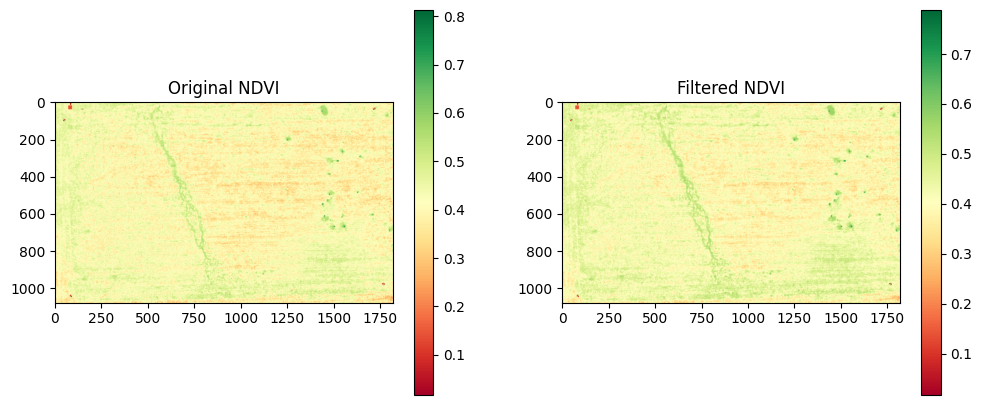

Benchmark Results:
Method: median, Kernel Size: 3, Sigma: None, Execution Time: 0.820 s, NDVI RMSE: 0.008720
Method: median, Kernel Size: 5, Sigma: None, Execution Time: 2.684 s, NDVI RMSE: 0.014687
Method: median, Kernel Size: 7, Sigma: None, Execution Time: 4.696 s, NDVI RMSE: 0.019309


In [3]:
import os
import time
import numpy as np
from scipy.ndimage import median_filter, gaussian_filter
import rasterio
from skimage.io import imsave
import matplotlib.pyplot as plt

def noise_reduction_filter(image, method='median', kernel_size=3, sigma=1.0):
    """
    Apply noise reduction to a multispectral image using a specified method.
    
    Parameters:
      image (np.ndarray): Input image array in shape (H, W, bands) with values in [0, 1].
      method (str): Filtering method. Options are 'median' or 'gaussian'.
      kernel_size (int): Size of the filtering kernel (must be odd).
      sigma (float): Standard deviation for Gaussian filtering (ignored for median).
      
    Returns:
      np.ndarray: Filtered image of same shape as input.
      
    Notes:
      - The median filter is applied independently on each band, preserving edges 
        (see :contentReference[oaicite:0]{index=0}).
      - The Gaussian filter uses the sigma value and a kernel size to control the amount of smoothing 
        (see :contentReference[oaicite:1]{index=1}).
    """
    filtered = np.empty_like(image)
    # Apply the chosen filter for each band independently.
    for band in range(image.shape[2]):
        if method == 'median':
            filtered[..., band] = median_filter(image[..., band], size=kernel_size)
        elif method == 'gaussian':
            # The 'truncate' parameter determines the filter window size:
            # truncate = ((kernel_size - 1) / 2) / sigma.
            truncate_val = ((kernel_size - 1) / 2) / sigma
            filtered[..., band] = gaussian_filter(image[..., band], sigma=sigma, truncate=truncate_val)
        else:
            raise ValueError("Method must be either 'median' or 'gaussian'.")
    return filtered

def compute_ndvi(image, nir_band_index, red_band_index):
    """
    Compute the Normalized Difference Vegetation Index (NDVI) from a multispectral image.
    
    NDVI is defined as:
        NDVI = (NIR - Red) / (NIR + Red)
    
    Parameters:
      image (np.ndarray): Input image in shape (H, W, bands) (assumed float in [0, 1]).
      nir_band_index (int): Index of the Near-Infrared (NIR) band.
      red_band_index (int): Index of the Red band.
      
    Returns:
      np.ndarray: NDVI image in shape (H, W) with values in [-1, 1].
      
    Reference for NDVI computation can be found in remote sensing literature :contentReference[oaicite:2]{index=2}.
    """
    nir = image[..., nir_band_index].astype(np.float32)
    red = image[..., red_band_index].astype(np.float32)
    ndvi = (nir - red) / (nir + red + 1e-10)  # small epsilon to avoid division by zero
    return ndvi

def validate_ndvi_improvement(original_image, filtered_image, nir_band_index, red_band_index):
    """
    Validate the effect of noise reduction by comparing the NDVI computed from the original
    image and the noise-reduced (filtered) image.
    
    This function calculates the RMSE between the two NDVI images. A lower RMSE may indicate 
    that the noise reduction has preserved the vegetation index characteristics (if the noise was 
    adversely affecting the NDVI calculation).
    
    Parameters:
      original_image (np.ndarray): Original multispectral image in shape (H, W, bands).
      filtered_image (np.ndarray): Noise-reduced image in shape (H, W, bands).
      nir_band_index (int): Index of the NIR band.
      red_band_index (int): Index of the Red band.
      
    Returns:
      float: RMSE value between the NDVI of the original and filtered images.
    """
    ndvi_orig = compute_ndvi(original_image, nir_band_index, red_band_index)
    ndvi_filt = compute_ndvi(filtered_image, nir_band_index, red_band_index)
    rmse = np.sqrt(np.mean((ndvi_orig - ndvi_filt) ** 2))
    return rmse

def batch_noise_reduction(input_dir, output_dir, method='median', kernel_size=3, sigma=1.0):
    """
    Process all images in a given directory by applying noise reduction and save the results.
    
    The images are assumed to be multispectral with shape (bands, H, W). This function reads each
    image (using rasterio), transposes it to (H, W, bands), applies noise reduction, and then saves
    the filtered image (scaled to 8-bit for visualization).
    
    Parameters:
      input_dir (str): Directory containing input images.
      output_dir (str): Directory where the filtered images will be saved.
      method (str): Filtering method ('median' or 'gaussian').
      kernel_size (int): Kernel size for filtering.
      sigma (float): Sigma for Gaussian filtering.
    """
    os.makedirs(output_dir, exist_ok=True)
    valid_extensions = ('.png', '.jpg', '.jpeg', '.tif', '.tiff')
    image_paths = [os.path.join(input_dir, fname)
                   for fname in os.listdir(input_dir)
                   if fname.lower().endswith(valid_extensions)]
    
    for path in image_paths:
        try:
            with rasterio.open(path) as src:
                # Read image in (bands, H, W)
                image = src.read().astype(np.float32)
            # Convert to (H, W, bands) and normalize if necessary (assumed to be in [0,1])
            image = np.transpose(image, (1, 2, 0))
            filtered_image = noise_reduction_filter(image, method=method, kernel_size=kernel_size, sigma=sigma)
            # For saving, clip values and scale to 8-bit
            save_img = np.clip(filtered_image, 0, 1)
            save_img = (save_img * 255).astype(np.uint8)
            output_path = os.path.join(output_dir, os.path.basename(path))
            imsave(output_path, save_img)
            print(f"Processed {path}")
        except Exception as e:
            print(f"Error processing {path}: {e}")

def benchmark_noise_reduction(image, method='median', kernel_sizes=[3, 5, 7], sigma_values=[1.0, 2.0],
                              nir_band_index=4, red_band_index=2, ground_truth_ndvi=None):
    """
    Benchmark the noise reduction function for various kernel sizes (and sigma values for Gaussian filtering).
    
    For each combination, the function measures the execution time and computes an NDVI metric.
    If a ground truth NDVI image is provided, the RMSE between the filtered NDVI and the ground truth is computed.
    Otherwise, it computes the RMSE between the original NDVI and the filtered NDVI.
    
    Parameters:
      image (np.ndarray): Input image in shape (H, W, bands).
      method (str): Filtering method ('median' or 'gaussian').
      kernel_sizes (list of int): List of kernel sizes to test.
      sigma_values (list of float): List of sigma values to test (only for 'gaussian'; ignored for 'median').
      nir_band_index (int): Index of the NIR band.
      red_band_index (int): Index of the Red band.
      ground_truth_ndvi (np.ndarray or None): Ground truth NDVI image for accuracy comparison.
      
    Returns:
      list of dict: Each dictionary contains method, kernel_size, sigma (if applicable), execution_time, and ndvi_rmse.
      
    References:
      - The idea of benchmarking noise reduction in terms of speed and quality is discussed in various image processing tutorials :contentReference[oaicite:3]{index=3}.
    """
    results = []
    for ksize in kernel_sizes:
        if method == 'median':
            start_time = time.time()
            filtered = noise_reduction_filter(image, method=method, kernel_size=ksize)
            exec_time = time.time() - start_time
            # Compare NDVI: if no ground truth, compare original vs filtered NDVI.
            if ground_truth_ndvi is not None:
                ndvi_rmse = np.sqrt(np.mean((compute_ndvi(filtered, nir_band_index, red_band_index) - ground_truth_ndvi) ** 2))
            else:
                ndvi_rmse = validate_ndvi_improvement(image, filtered, nir_band_index, red_band_index)
            results.append({
                'method': method,
                'kernel_size': ksize,
                'sigma': None,
                'execution_time': exec_time,
                'ndvi_rmse': ndvi_rmse
            })
        elif method == 'gaussian':
            for sigma in sigma_values:
                start_time = time.time()
                filtered = noise_reduction_filter(image, method=method, kernel_size=ksize, sigma=sigma)
                exec_time = time.time() - start_time
                if ground_truth_ndvi is not None:
                    ndvi_rmse = np.sqrt(np.mean((compute_ndvi(filtered, nir_band_index, red_band_index) - ground_truth_ndvi) ** 2))
                else:
                    ndvi_rmse = validate_ndvi_improvement(image, filtered, nir_band_index, red_band_index)
                results.append({
                    'method': method,
                    'kernel_size': ksize,
                    'sigma': sigma,
                    'execution_time': exec_time,
                    'ndvi_rmse': ndvi_rmse
                })
    return results

# --- Main block for testing the module independently ---
if __name__ == "__main__":
    # For modular testing of Task 3, load a sample image.
    sample_image_path = "testfiles/20180627_seq_50m_NC.tif"  # Change this path as needed.
    try:
        with rasterio.open(sample_image_path) as src:
            # Read image in (bands, H, W)
            image = src.read().astype(np.float32)
        # Convert to (H, W, bands)
        image = np.transpose(image, (1, 2, 0))
        # Normalize if necessary (here we assume the image is already scaled to [0,1])
    except Exception as e:
        print("Error loading sample image, using a dummy image for testing:", e)
        image = np.random.rand(100, 100, 5).astype(np.float32)
    
    # Choose filtering parameters
    method = 'median'  # or 'gaussian'
    kernel_size = 3
    sigma = 1.0  # used only if method is 'gaussian'
    
    # Apply noise reduction independently and display NDVI results.
    filtered_image = noise_reduction_filter(image, method=method, kernel_size=kernel_size, sigma=sigma)
    
    # Assume that for NDVI, the NIR band is at index 4 and red band is at index 3.
    nir_band_index = 4
    red_band_index = 3
    ndvi_original = compute_ndvi(image, nir_band_index, red_band_index)
    ndvi_filtered = compute_ndvi(filtered_image, nir_band_index, red_band_index)
    
    # Display NDVI images side by side.
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(ndvi_original, cmap='RdYlGn')
    plt.title("Original NDVI")
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(ndvi_filtered, cmap='RdYlGn')
    plt.title("Filtered NDVI")
    plt.colorbar()
    plt.show()
    
    # Run benchmarking for various parameter settings.
    bench_results = benchmark_noise_reduction(image, method=method, kernel_sizes=[3, 5, 7],
                                              sigma_values=[1.0, 2.0],
                                              nir_band_index=nir_band_index, red_band_index=red_band_index)
    print("Benchmark Results:")
    for res in bench_results:
        # Convert the NDVI RMSE to a Python float and format it with, say, 6 decimal places.
        ndvi_rmse_str = f"{float(res['ndvi_rmse']):.6f}"
        print(f"Method: {res['method']}, Kernel Size: {res['kernel_size']}, "
            f"Sigma: {res['sigma']}, Execution Time: {res['execution_time']:.3f} s, "
            f"NDVI RMSE: {ndvi_rmse_str}")

